In [1]:
import sys
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
kit_blue_1 = "#4664AA"
kit_blue_2 = "#7D92C3"

run = "athlete" # "writtenwork_depth"
res_glob = pd.read_csv(f"out/_results_{run}.csv", index_col=0)
# res_wikidata_glob = pd.read_csv("out/_results_wikidata.csv", index_col=0)
# res_athlete_glob = pd.read_csv("out/_results_athlete.csv", index_col=0)
# res_random_glob = pd.read_csv("out/_results_random_run.csv", index_col=0)

# Control which classes to analyze. Add or remove rows in res_glob DataFrame
# res_glob = pd.concat([res_glob, res_athlete_glob, res_wikidata_glob, res_random_glob])
# res_glob = res_glob.loc[[
#                         "WrittenWork", "WrittenWorkRandom",
#                         "AcademicJournal", "AcademicJournalRandom", "ScientificJournalWikidata",
#                         "Comic", "ComicRandom", "ComicWikidata",
#                         "Manga", "MangaRandom",
#                         "Novel",
#                         "PeriodicalLiterature", "PeriodicalLiteratureRandom",
#                         "Newspaper", "NewspaperRandom",
#                         "Poem", "PoemRandom",
#                         "Boxer", "BoxerWikidata",
#                         "Cyclist", "CyclistWikidata",
#                         ]]

res_disp = res_glob.copy()
# Format integer
res_disp["n_t"] = res_disp["n_t"].map("{:,.0f}".format)
res_disp["n_b"] = res_disp["n_b"].map("{:,.0f}".format)
res_disp["m_g"] = res_disp["m_g"].map("{:,.0f}".format)
res_disp["ndisc_t"] = res_disp["ndisc_t"].map("{:,.0f}".format)
res_disp["ndisc_b"] = res_disp["ndisc_b"].map("{:,.0f}".format)
res_disp["m_t"] = res_disp["m_t"].map("{:,.0f}".format)
res_disp["m_b"] = res_disp["m_b"].map("{:,.0f}".format)
res_disp["k_0_t"] = res_disp["k_0_t"].map("{:,.0f}".format)
res_disp["k_0_b"] = res_disp["k_0_b"].map("{:,.0f}".format)
res_disp["k_med_t"] = res_disp["k_med_t"].map("{:,.0f}".format)
res_disp["c_med_t"] = res_disp["c_med_t"].map("{:,.0f}".format)
res_disp["w_med_t"] = res_disp["w_med_t"].map("{:,.0f}".format)
res_disp["k_med_b"] = res_disp["k_med_b"].map("{:,.0f}".format)
res_disp["c_med_b"] = res_disp["c_med_b"].map("{:,.0f}".format)
res_disp["w_med_b"] = res_disp["w_med_b"].map("{:,.0f}".format)

# Format float with two decimals as standard
# pd.options.display.float_format = '{:,.2f}'.format # https://stackoverflow.com/questions/20937538/how-to-display-pandas-dataframe-of-floats-using-a-format-string-for-columns

# Format float with four decimals
res_disp["mean_dens_t"] = res_disp["mean_dens_t"].map("{:,.4f}".format)
res_disp["rc_dens_t"] = res_disp["rc_dens_t"].map("{:,.4f}".format)
res_disp["rc_ncomp_t"] = res_disp["rc_ncomp_t"].map("{:,.4f}".format)
res_disp["rc_slcc_t"] = res_disp["rc_slcc_t"].map("{:,.4f}".format)
res_disp["mean_dens_b"] = res_disp["mean_dens_b"].map("{:,.4f}".format)
res_disp["rc_dens_b"] = res_disp["rc_dens_b"].map("{:,.4f}".format)
res_disp["rc_ncomp_b"] = res_disp["rc_ncomp_b"].map("{:,.4f}".format)
res_disp["rc_slcc_b"] = res_disp["rc_slcc_b"].map("{:,.4f}".format)

print(res_glob.index.tolist())

['Athlete', 'Boxer', 'AmateurBoxer', 'GridironFootballPlayer', 'AmericanFootballPlayer', 'MotorsportRacer', 'RacingDriver', 'FormulaOneRacer', 'NascarDriver', 'WinterSportPlayer', 'Curler', 'IceHockeyPlayer', 'Skier', 'BaseballPlayer', 'BasketballPlayer', 'ChessPlayer', 'Cyclist', 'Fencer', 'GolfPlayer', 'HorseRider', 'PokerPlayer', 'SoccerPlayer', 'TennisPlayer']


,n_t,n_b,k_t_g,k_b_g
WrittenWork,90862.0,6235.0,15.743501,229.428388
Book,54578.0,4816.0,15.274854,173.104444
Novel,37.0,64.0,4.081081,2.359375
Comic,6688.0,996.0,18.461124,123.963855
ComicStrip,561.0,428.0,6.985740,9.156542
Manga,3783.0,459.0,21.421623,176.553377
Drama,2530.0,813.0,26.768775,83.302583
Letter,465.0,534.0,8.393548,7.308989
PeriodicalLiterature,22235.0,1743.0,16.565145,211.317269
AcademicJournal,7688.0,561.0,22.739334,311.622103


,n_t,n_b,k_t_g,k_b_g
AnatomicalStructure,7373.0,2458.0,9.936661,29.805940
Artery,449.0,134.0,15.928731,53.373134
Bone,604.0,257.0,9.971854,23.435798
Brain,632.0,166.0,12.928797,49.222892
Lymph,82.0,86.0,11.621951,11.081395
Muscle,315.0,98.0,16.625397,53.438776
Nerve,394.0,131.0,13.149746,39.549618
Vein,257.0,45.0,14.992218,85.622222


,n_t,n_b,k_t_g,k_b_g
Athlete,404915.0,10030.0,23.804312,960.989332
Boxer,6457.0,535.0,19.388571,234.003738
AmateurBoxer,445.0,80.0,18.067416,100.500000
GridironFootballPlayer,26560.0,1582.0,30.873870,518.337547
AmericanFootballPlayer,21579.0,1467.0,32.475879,477.707566
MotorsportRacer,7838.0,1204.0,21.165476,137.786545
RacingDriver,5454.0,894.0,21.190869,129.278523
FormulaOneRacer,902.0,281.0,26.060976,83.654804
NascarDriver,986.0,374.0,26.985801,71.144385
WinterSportPlayer,27278.0,3425.0,25.829203,205.713577


,n_t,n_b,k_t_g,k_b_g
BoxerWikidata,10936.0,334.0,10.717904,350.931138
CyclistWikidata,18860.0,283.0,11.876935,791.515901
ComicWikidata,2986.0,96.0,3.803416,118.302083
ScientificJournalWikidata,42283.0,174.0,8.345813,2028.080460


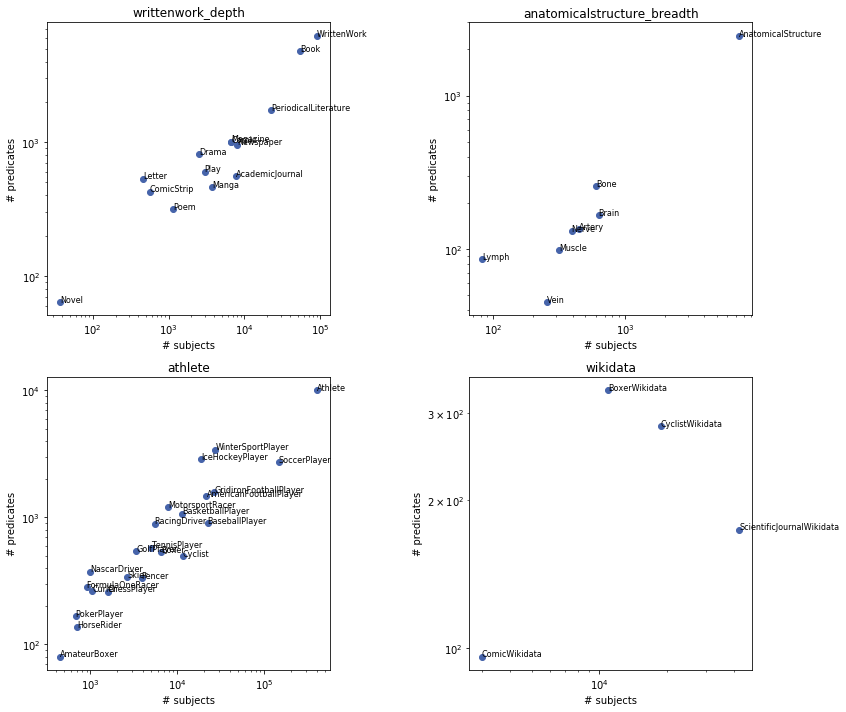

In [3]:
# Number of subjects and predicates per class

res = res_glob

runs = [
    "writtenwork_depth",
    "anatomicalstructure_breadth",
    "athlete",
    "wikidata",
]

nrows = math.ceil(len(runs) / 2)
fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex="none", sharey="none", figsize=(12, nrows*5))
for run in runs:
    res = pd.read_csv(f"out/_results_{run}.csv", index_col=0)
    display(res[["n_t", "n_b", "k_t_g", "k_b_g"]])
    runnr = runs.index(run)
    row = math.floor(runnr / 2)
    col = runnr % 2
    axes[row, col].set_title(run)
    axes[row, col].set_xlabel("# subjects")
    axes[row, col].set_ylabel("# predicates")
    
    axes[row, col].scatter(res["n_t"], res["n_b"], color=kit_blue_1, marker="o")
    for i, label in enumerate(res.index):
        axes[row, col].annotate(label, (res["n_t"][i], res["n_b"][i]), fontsize=8)
    axes[row, col].set_xscale("log")
    axes[row, col].set_yscale("log")
    axes[row, col].set_xlabel("# subjects")
    axes[row, col].set_ylabel("# predicates")

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

Compare relative values e.g. (k_mean_t / n_t) ?


,n_t,n_b,ndisc_t,ndisc_b,k_t_g,k_b_g,k_mean_t,k_sd_t,k_mean_b,k_sd_b,k_med_t,k_med_b,superclass
Athlete,"404,915","10,030",5,3,23.804312,960.989332,389942.600672,46501.647997,141.170639,316.442905,"397,634",58,Person
Boxer,"6,457",535,0,0,19.388571,234.003738,6188.782716,806.871368,80.676636,87.724793,"6,308",46,Athlete
AmateurBoxer,445,80,0,0,18.067416,100.500000,406.997753,83.233434,33.925000,20.900822,424,28,AmateurBoxer
GridironFootballPlayer,"26,560","1,582",0,0,30.873870,518.337547,26116.387952,2019.505431,98.285714,132.572454,"26,350",51,Athlete
AmericanFootballPlayer,"21,579","1,467",0,0,32.475879,477.707566,21177.732240,1749.866400,96.154056,127.296404,"21,379",51,GridironFootballPlayer
MotorsportRacer,"7,838","1,204",0,0,21.165476,137.786545,7196.368206,1056.392854,80.048173,113.029129,"7,512",41,Athlete
RacingDriver,"5,454",894,0,0,21.190869,129.278523,4902.859919,781.192351,67.326622,91.433737,"5,171",36,MotorsportRacer
FormulaOneRacer,902,281,0,11,26.060976,83.654804,882.283814,58.603249,49.140741,48.889166,890,35,RacingDriver
NascarDriver,986,374,0,0,26.985801,71.144385,951.395538,104.550675,54.914439,53.834845,966,36,RacingDriver
WinterSportPlayer,"27,278","3,425",0,0,25.829203,205.713577,24921.523499,4123.415883,137.226277,190.696455,"26,072",61,Athlete


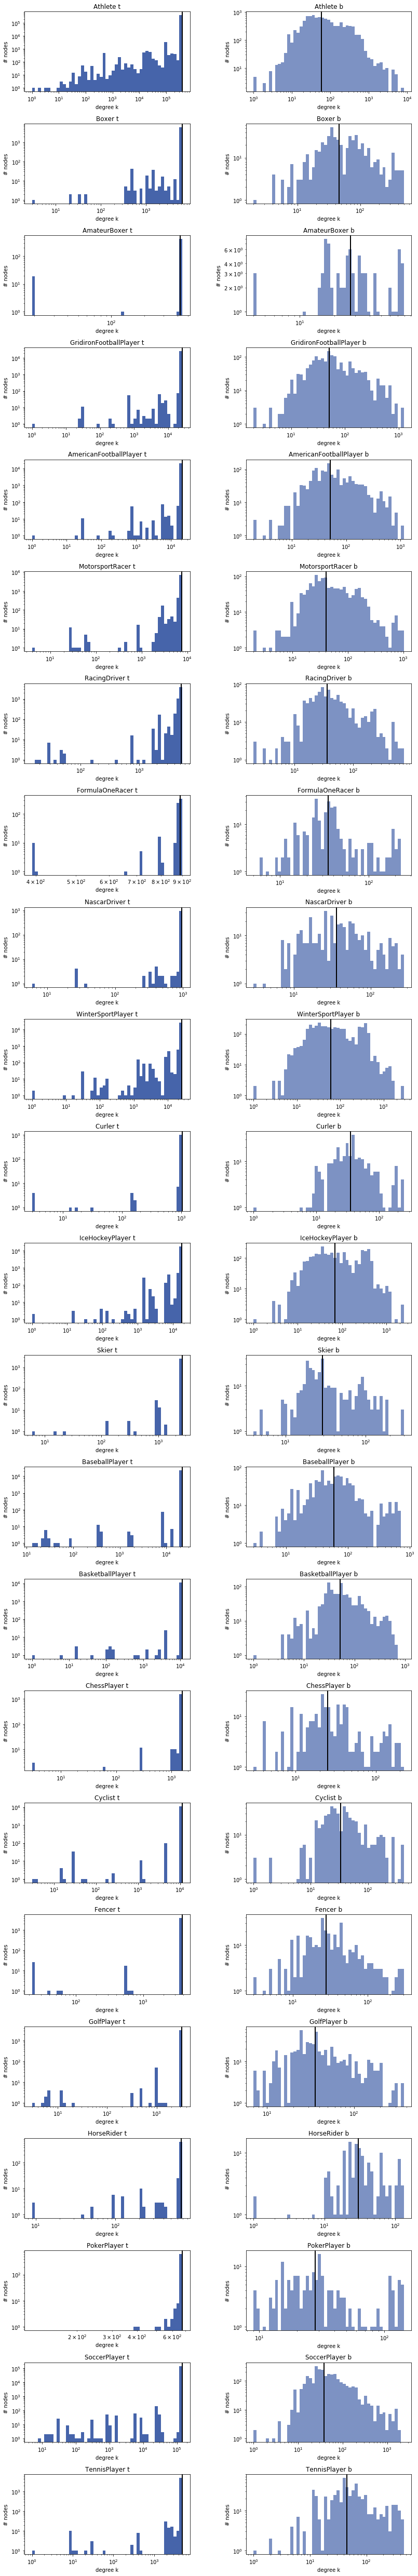

In [4]:
# Degree histogram of top and bot onemode graphs (log log scale)
# Wikidata degrees are most times 100% @ one k

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)
nrows = len(classes)
fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex="none", sharey="none", figsize=(12, 3 * nrows))
for classname in classes:
    row = classes.index(classname)
    # Top
    with open(f"out/{classname}/{classname}.t.k.json", "r") as input_file:
        dist = json.load(input_file)
    n_t = res.loc[classname, "n_t"]
    k = []
    for degree, count in dist.items():
        k.extend([int(degree)] * count)

    logbins = np.geomspace(min(k), max(k), 50) # geomspace cannot include 0 (disc nodes)
    axes[row, 0].set_xscale("log")
    axes[row, 0].set_yscale("log")
    axes[row, 0].set_title(classname + " t")
    axes[row, 0].axvline(np.median(k), color='k', linewidth=2)
    axes[row, 0].set_xlabel("degree k")
    axes[row, 0].set_ylabel("# nodes")
    # min_ylim, max_ylim = axes[row, 0].get_ylim()
    # axes[row, 0].text(np.median(k) * 1.1, max_ylim * 0.9, 'Mean: {:.2f}'.format(np.median(k))) # Draw median value
    hist, bins, _ = axes[row, 0].hist(k, bins=logbins, color=kit_blue_1)
    # Bot
    with open(f"out/{classname}/{classname}.b.k.json", "r") as input_file:
        dist = json.load(input_file)
    n_b = res.loc[classname, "n_b"]
    k = []
    for degree, count in dist.items():
        k.extend([int(degree)] * count)

    logbins = np.geomspace(min(k), max(k), 50)
    axes[row, 1].set_xscale("log")
    axes[row, 1].set_yscale("log")
    axes[row, 1].set_title(classname + " b")
    axes[row, 1].axvline(np.median(k), color='k', linewidth=2)
    axes[row, 1].set_xlabel("degree k")
    axes[row, 1].set_ylabel("# nodes")
    hist, bins, _ = axes[row, 1].hist(k, bins=logbins, color=kit_blue_2)

print("Compare relative values e.g. (k_mean_t / n_t) ?")
display(res_disp[["n_t", "n_b", "ndisc_t", "ndisc_b", "k_t_g", "k_b_g", "k_mean_t", "k_sd_t", "k_mean_b", "k_sd_b", "k_med_t", "k_med_b", "superclass"]])

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

In [5]:
# Get subjects and predicates whose nodedegree is in given range

def get_nodes_k_range(classname, onemode, start, end):
    with open(f"out/{classname}/{classname}.{onemode}.nk.json", "r") as in_file:
        nodedegrees = json.load(in_file)
    myresults = []
    for entity, degree in nodedegrees.items():
        if degree in range(start, end):
            myresults.append((entity, degree))
    myresults.sort(key=lambda x: x[1])
    print(f"{classname} {onemode}")
    for entity, degree in myresults[:20]:
        print(degree, entity)

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)
classes = ["Cyclist"]
for classname in classes:
    get_nodes_k_range(classname, "t", 900, 2000)
    get_nodes_k_range(classname, "b", 0, 10)
    print("\n")
    
# myresult = {key: mydict[key] for key in sorted(mydict, key=mydict.get, reverse=True)[:9]} # Get n highest/lowest pairs

Cyclist t
1198 http://dbpedia.org/resource/Nácor_Burgos
1198 http://dbpedia.org/resource/Tullio_Campagnolo
1198 http://dbpedia.org/resource/The_Collective_(mountain_biking)
1198 http://dbpedia.org/resource/Raphaël_Gagné
1198 http://dbpedia.org/resource/Haro_Bikes
1198 http://dbpedia.org/resource/Mooinjer_veggey
1198 http://dbpedia.org/resource/Alexis_Gewertz_Shepard
1198 http://dbpedia.org/resource/Tristyn_Kronk
1198 http://dbpedia.org/resource/Ryan_Nyquist
1198 http://dbpedia.org/resource/Richard_Sachs
1198 http://dbpedia.org/resource/Kris_Holm
1362 http://dbpedia.org/resource/Danny_Nelissen
Cyclist b
1 http://dbpedia.org/property/section
1 http://dbpedia.org/property/nonum
1 http://dbpedia.org/property/limit
2 http://dbpedia.org/property/side
2 http://dbpedia.org/property/top
2 http://dbpedia.org/property/num
6 http://dbpedia.org/property/cname
7 http://dbpedia.org/property/coordinates
7 http://dbpedia.org/property/birth
7 http://dbpedia.org/property/sname
7 http://dbpedia.org/proper

,m_t,m_b,w_med_t,w_med_b,superclass
Athlete,"78,945,829,219","707,759",8,2,Person
Boxer,"19,980,485","21,581",8,1,Athlete
AmateurBoxer,"90,557","1,357",14,3,AmateurBoxer
GridironFootballPlayer,"346,825,632","77,744",15,2,Athlete
AmericanFootballPlayer,"228,497,142","70,529",17,2,GridironFootballPlayer
MotorsportRacer,"28,202,567","48,189",8,2,Athlete
RacingDriver,"13,370,099","30,095",7,2,MotorsportRacer
FormulaOneRacer,"397,910","6,634",22,2,RacingDriver
NascarDriver,"469,038","10,269",11,2,RacingDriver
WinterSportPlayer,"339,904,659","235,000",10,1,Athlete


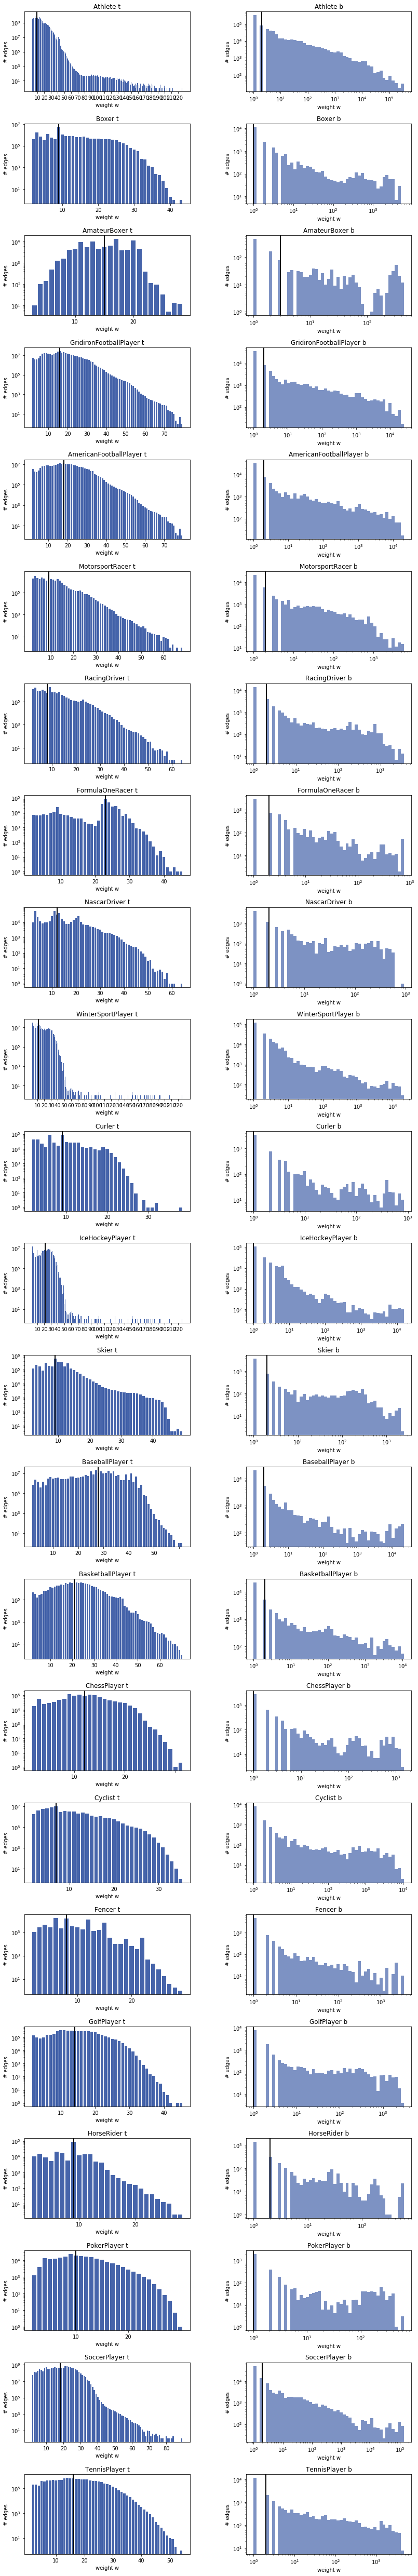

In [6]:
# Weight hist top and bot
# Difficulty: m_t very large, manual for t
# How to limit x axis?

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)

# pd.options.display.float_format = '{:,.0f}'.format
display(res_disp[["m_t", "m_b", "w_med_t", "w_med_b", "superclass"]]) # TODO: sdev

fig, axes = plt.subplots(nrows=len(classes), ncols=2, sharex="none", sharey="none", figsize=(12, 3 * len(classes)))
for classname in classes:
    row = classes.index(classname)
    # Top (density dist)
    w = []
    pw = []
    with open(f"out/{classname}/{classname}.t.w.json", "r") as input_file:
        dist = json.load(input_file)
    median = res.loc[classname, "w_med_t"]
    for weight, count in dist.items():
        if int(weight) > 0:
            w.append(int(weight))
            pw.append(count)
    axes[row, 0].bar(w, pw, align='center', color=kit_blue_1)
    axes[row, 0].axvline(median, color='k', linewidth=2)
    axes[row, 0].set_title(classname + " t")
    axes[row, 0].set_yscale("log")
    axes[row, 0].tick_params(axis="x", reset=True, top=False)
    axes[row, 0].set_xticks(range(9, max(w), 10))
    axes[row, 0].set_xticklabels(range(10, max(w), 10))
    axes[row, 0].set_xlabel("weight w")
    axes[row, 0].set_ylabel("# edges")
    # Bot (hist)
    w = []
    with open(f"out/{classname}/{classname}.b.w.json", "r") as input_file:
        dist = json.load(input_file)
    for weight, count in dist.items():
        if int(weight) > 0:
            w.extend([int(weight)] * count)
    
    logbins = np.geomspace(min(w), max(w), 50)
    axes[row, 1].set_xscale("log")
    axes[row, 1].set_yscale("log")
    axes[row, 1].set_title(classname + " b")
    axes[row, 1].set_xlabel("weight w")
    axes[row, 1].set_ylabel("# edges")
    axes[row, 1].axvline(np.median(w), color='k', linewidth=2)
    hist, bins, _ = axes[row, 1].hist(w, bins=logbins, color=kit_blue_2)

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

In [7]:
# TODO: Get list of subject pairs with high w and low w
# TODO: Get list of predicate pairs with high w and low w
# How to implement this for huge .t.csv edgelist files?

,n_t,n_b,k_t_g,k_b_g,c_mean_t,c_sd_t,c_mean_b,c_sd_b,c_med_t,c_med_b,superclass
Athlete,"404,915.00","10,030.00",23.80,960.99,"3,574,366.40","1,420,112.24","26,970.39","306,942.73","3,752,998.50",95.00,Person
Boxer,"6,457.00",535.00,19.39,234.00,"65,733.70","25,860.46","5,297.63","18,686.67","64,723.00",69.00,Athlete
AmateurBoxer,445.00,80.00,18.07,100.50,"5,676.76","1,575.45","1,512.67","2,432.79","6,043.00",175.00,AmateurBoxer
GridironFootballPlayer,"26,560.00","1,582.00",30.87,518.34,"396,031.15","118,030.46","17,311.53","81,987.99","402,809.00",67.00,Athlete
AmericanFootballPlayer,"21,579.00","1,467.00",32.48,477.71,"356,361.34","104,749.38","16,616.65","76,061.49","369,938.00",72.00,GridironFootballPlayer
MotorsportRacer,"7,838.00","1,204.00",21.17,137.79,"55,426.96","21,924.68","3,445.46","13,186.29","55,883.00",69.00,Athlete
RacingDriver,"5,454.00",894.00,21.19,129.28,"38,640.13","16,409.66","3,217.53","10,957.81","38,177.00",49.00,MotorsportRacer
FormulaOneRacer,902.00,281.00,26.06,83.65,"16,290.60","4,835.24","1,034.30","2,874.77","17,935.00",64.50,RacingDriver
NascarDriver,986.00,374.00,26.99,71.14,"11,833.96","4,554.52","1,640.36","3,991.30","11,737.50",66.00,RacingDriver
WinterSportPlayer,"27,278.00","3,425.00",25.83,205.71,"312,893.18","157,716.13","6,216.43","45,972.40","328,897.50",109.00,Athlete


Compare relative values e.g. (k_mean_t / n_t) ?


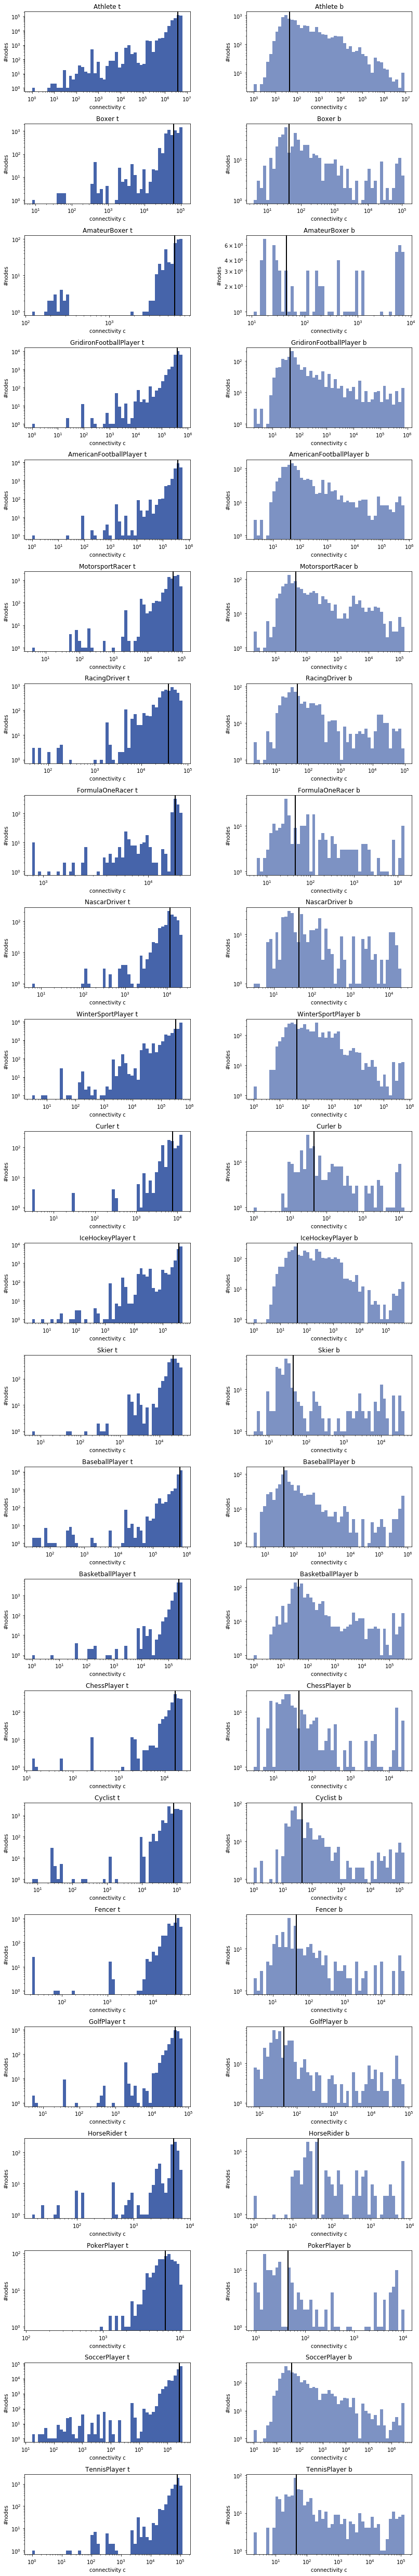

In [8]:
# Connectivity histogram of top and bot onemode graphs

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)

pd.options.display.float_format = '{:,.2f}'.format
display(res[["n_t", "n_b", "k_t_g", "k_b_g", "c_mean_t", "c_sd_t", "c_mean_b", "c_sd_b", "c_med_t", "c_med_b", "superclass"]])
print("Compare relative values e.g. (k_mean_t / n_t) ?")

nrows = len(classes)
fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex="none", sharey="none", figsize=(12, 3 * nrows))
for classname in classes:
    row = classes.index(classname)
    # Top
    with open(f"out/{classname}/{classname}.t.c.json", "r") as input_file:
        dist = json.load(input_file)
    c = []
    for connectivity, count in dist.items():
        c.extend([int(connectivity)] * count)

    logbins = np.geomspace(min(c), max(c), 50) # geomspace cannot include 0 (disc nodes)
    axes[row, 0].set_xscale("log")
    axes[row, 0].set_yscale("log")
    axes[row, 0].set_title(classname + " t")
    axes[row, 0].axvline(np.median(c), color='k', linewidth=2)
    axes[row, 0].set_xlabel("connectivity c")
    axes[row, 0].set_ylabel("#nodes")
    # min_ylim, max_ylim = axes[row, 0].get_ylim()
    # axes[row, 0].text(np.median(k) * 1.1, max_ylim * 0.9, 'Mean: {:.2f}'.format(np.median(k))) # Draw median value
    hist, bins, _ = axes[row, 0].hist(c, bins=logbins, color=kit_blue_1)
    # Bot
    with open(f"out/{classname}/{classname}.b.c.json", "r") as input_file:
        dist = json.load(input_file)
    c = []
    for connectivity, count in dist.items():
        c.extend([int(connectivity) for i in range(0, count)])

    logbins = np.geomspace(min(c), max(c), 50)
    axes[row, 1].set_xscale("log")
    axes[row, 1].set_yscale("log")
    axes[row, 1].set_title(classname + " b")
    axes[row, 1].axvline(np.median(k), color='k', linewidth=2)
    axes[row, 1].set_xlabel("connectivity c")
    axes[row, 1].set_ylabel("#nodes")
    hist, bins, _ = axes[row, 1].hist(c, bins=logbins, color=kit_blue_2)

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

In [9]:
# Get subjects and predicates whose connectivity is in given range

def get_nodes_c_range(classname, onemode, start, end):
    with open(f"out/{classname}/{classname}.{onemode}.nc.json", "r") as in_file:
        nodeconnectivities = json.load(in_file)
    myresults = []
    for entity, connectivity in nodeconnectivities.items():
        if connectivity in range(start, end):
            myresults.append((entity, connectivity))
    myresults.sort(key=lambda x: x[1])
    print(f"{classname} {onemode}")
    for entity, connectivity in myresults[:20]:
        print(connectivity, entity)

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)
classes = ["Comic"]
for classname in classes:
    get_nodes_c_range(classname, "t", 10, 200)
    get_nodes_c_range(classname, "b", 40000, 100000)
    print("\n")
    
# myresult = {key: mydict[key] for key in sorted(mydict, key=mydict.get, reverse=True)[:9]} # Get n highest/lowest pairs

Comic t
22 http://dbpedia.org/resource/Cake_theory
25 http://dbpedia.org/resource/Teller_Amendment
32 http://dbpedia.org/resource/Watch_Out_Beagles_About
32 http://dbpedia.org/resource/Is
61 http://dbpedia.org/resource/Food_Additives_Amendment_of_1958
72 http://dbpedia.org/resource/The_Belles_of_St._Lemons
77 http://dbpedia.org/resource/Kefauver_Harris_Amendment
84 http://dbpedia.org/resource/Protect_America_Act_of_2007
86 http://dbpedia.org/resource/Chemical_Diversion_and_Trafficking_Act
89 http://dbpedia.org/resource/Refugee_Act
99 http://dbpedia.org/resource/Johnny_Bean_from_Happy_Bunny_Green
101 http://dbpedia.org/resource/Ecosystem_health
101 http://dbpedia.org/resource/Billy_the_Cat_and_Katie
101 http://dbpedia.org/resource/Pork_barrel
101 http://dbpedia.org/resource/Illinois_Fair_Tax
101 http://dbpedia.org/resource/Store_Wars
115 http://dbpedia.org/resource/Ball_Boy_(Beano)
115 http://dbpedia.org/resource/Number_13_Beano_Street
115 http://dbpedia.org/resource/The_Numskulls
115 h

n_t_super 404915.0
n_b_super 10030.0
n_b_th Athlete 6.0
n_b_th Boxer 12.0
n_b_th AmateurBoxer 12.0
n_b_th GridironFootballPlayer 11.0
n_b_th AmericanFootballPlayer 11.0
n_b_th MotorsportRacer 11.0
n_b_th RacingDriver 11.0
n_b_th FormulaOneRacer 12.0
n_b_th NascarDriver 12.0
n_b_th WinterSportPlayer 10.0
n_b_th Curler 12.0
n_b_th IceHockeyPlayer 10.0
n_b_th Skier 12.0
n_b_th BaseballPlayer 11.0
n_b_th BasketballPlayer 11.0
n_b_th ChessPlayer 12.0
n_b_th Cyclist 12.0
n_b_th Fencer 12.0
n_b_th GolfPlayer 12.0
n_b_th HorseRider 12.0
n_b_th PokerPlayer 12.0
n_b_th SoccerPlayer 10.0
n_b_th TennisPlayer 12.0


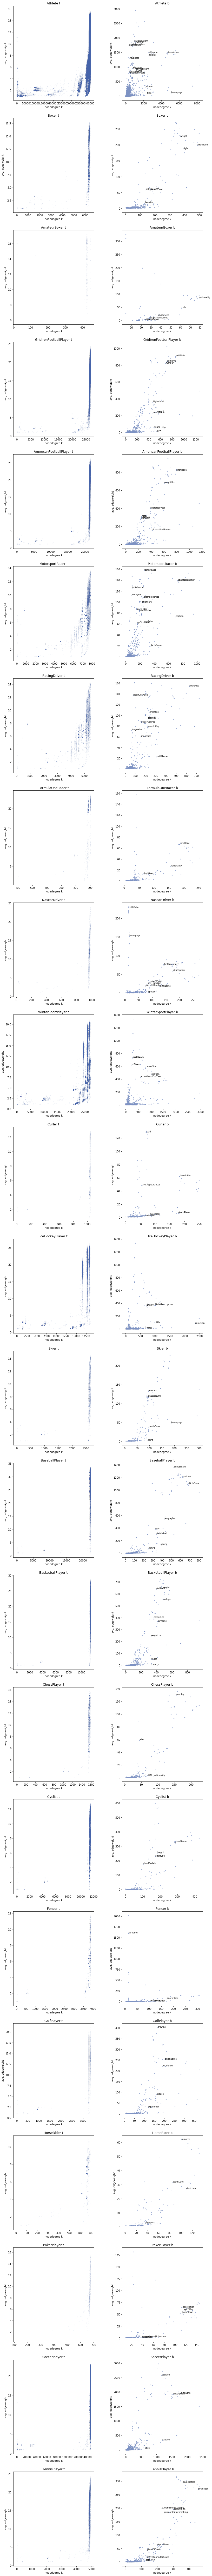

In [10]:
# Average edge weight (connectivity based) over degree per entity scatterplot

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)

nrows = len(classes)
fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex="none", sharey="none", figsize=(12, nrows*6))
n_t_super = res["n_t"].iloc[0]
n_b_super = res["n_b"].iloc[0]
print("n_t_super", n_t_super)
print("n_b_super", n_b_super)
for classname in classes:
    row = classes.index(classname)
    # Top
    n = []
    k = []
    c = []
    with open(f"out/{classname}/{classname}.t.nk.json", "r") as input_file:
        nk_dist = json.load(input_file)
    with open(f"out/{classname}/{classname}.t.nc.json", "r") as input_file:
        nc_dist = json.load(input_file)

    for key, value in nk_dist.items():
        n.append(key.split('/')[-1][:9])
        k.append(value)
        c.append(nc_dist.get(key) / value)

    axes[row, 0].set_title(classname + " t")
    axes[row, 0].set_xlabel("nodedegree k")
    axes[row, 0].set_ylabel("avg. edgeweight")
    axes[row, 0].scatter(k, c, s=5, color=kit_blue_1+"0a")
    # n_t = res.loc[classname, "n_t"]
    # n_t_th = round(np.interp(n_t, [0, n_t_super], [100, 600]))
    # print(f"n_t_th {classname} {n_t_th}")
    # for i, label in enumerate(n): # Only annotate some entities
    #     if (round(c[i]) % 2 == 0 and i % n_t_th == 0):
    #         axes[row, 1].annotate(label, (k[i], c[i]), fontsize=8)
    # Bot
    n = []
    k = []
    c = []
    with open(f"out/{classname}/{classname}.b.nk.json", "r") as input_file:
        nk_dist = json.load(input_file)
    with open(f"out/{classname}/{classname}.b.nc.json", "r") as input_file:
        nc_dist = json.load(input_file)

    for key, value in nk_dist.items():
        n.append(key.split('/')[-1])
        k.append(value)
        c.append(nc_dist.get(key) / value)
    
    axes[row, 1].set_title(classname + " b")
    axes[row, 1].set_xlabel("nodedegree k")
    axes[row, 1].set_ylabel("avg. edgeweight")
    axes[row, 1].scatter(k, c, s=5, color=kit_blue_2+"aa")
    n_b = res.loc[classname, "n_b"]
    n_b_th = round(np.interp(n_b, [0, n_b_super], [12, 6]))
    print(f"n_b_th {classname} {n_b_th}")
    for i, label in enumerate(n): # Annotate only some entities
        if ((k[i] > (axes[row, 1].get_xlim()[1] * 0.25) and i % n_b_th == 0)
            or (c[i] > (axes[row, 1].get_ylim()[1] * 0.25) and i % n_b_th == 0)):
            axes[row, 1].annotate(label, (k[i], c[i]), fontsize=8)

# TODO: Query subject and predicate examples from nk and nc (c == k * avg. edgeweight)

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

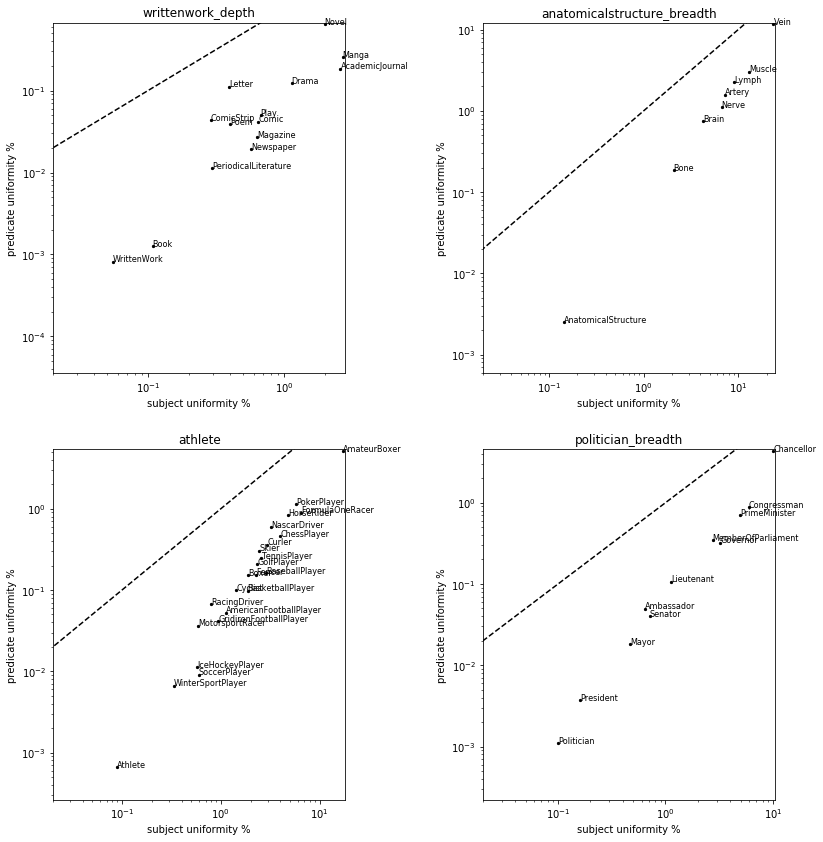

In [11]:
# rc_t over rc_b (in %) for each class and each run scatterplot
runs = [
    "writtenwork_depth",
    "anatomicalstructure_breadth",
    "athlete",
    "politician_breadth",
]

nrows = math.ceil(len(runs) / 2)
fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex="none", sharey="none", figsize=(12, nrows*6))
for run in runs:
    label = []
    sclass = []
    subj = []
    pred = []
    res = pd.read_csv(f"out/_results_{run}.csv", index_col=0)
    for classname in res.index.values:
        label.append(classname)
        sclass.append(res.loc[classname, "superclass"])
        subj.append(res.loc[classname, "rc_dens_t"] * 100)
        pred.append(res.loc[classname, "rc_dens_b"] * 100)

    runnr = runs.index(run)
    row = math.floor(runnr / 2)
    col = runnr % 2
    axes[row, col].set_title(run)
    axes[row, col].set_xlabel("subject uniformity %")
    axes[row, col].set_ylabel("predicate uniformity %")
    axes[row, col].scatter(subj, pred, marker="o", s=5, color="black")
    for i, label in enumerate(label):
        axes[row, col].annotate(label, (subj[i], pred[i]), fontsize=8)

    xmin, xmax = axes[row, col].get_xlim()
    ymin, ymax = axes[row, col].get_ylim()
    axes[row, col].set_xlim(0.02, xmax)
    axes[row, col].set_ylim(ymin - (ymin * 1.001), ymax)

    axes[row, col].set_xscale("log")
    axes[row, col].set_yscale("log")

    axes[row, col].autoscale(False)

    origin_x = np.linspace(0.001,100,3)
    origin_y = origin_x
    axes[row, col].plot(origin_x, origin_y, color="black", linestyle="dashed")

plt.subplots_adjust(wspace=10, hspace=10)
plt.tight_layout()

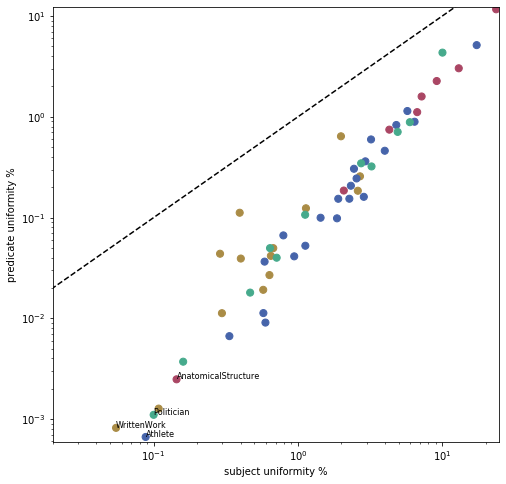

In [26]:
# rc_t over rc_b (in %) for each class and each run in one single scatterplot
runs = [
    "writtenwork_depth",
    "anatomicalstructure_breadth",
    "athlete",
    "politician_breadth",
]

label = []
subj = []
pred = []
color = []

for run in runs:
    res = pd.read_csv(f"out/_results_{run}.csv", index_col=0)
    for classname in res.index.values:
        if classname in ["WrittenWork", "AnatomicalStructure", "Athlete", "Politician"]:
            label.append(classname)
        else:
            label.append("")
        subj.append(res.loc[classname, "rc_dens_t"] * 100)
        pred.append(res.loc[classname, "rc_dens_b"] * 100)
        if run == "writtenwork_depth":
            color.append("#aa8c46")
        elif run == "anatomicalstructure_breadth":
            color.append("#aa4664")
        elif run == "athlete":
            color.append("#4664aa")
        elif run == "politician_breadth":
            color.append("#46aa8c")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.set_xlabel("subject uniformity %")
ax.set_ylabel("predicate uniformity %")
ax.scatter(subj, pred, marker="o", s=50, color=color)
for i, label in enumerate(label):
    ax.annotate(label, (subj[i], pred[i]), fontsize=8)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_xlim(0.02, xmax)
ax.set_ylim(ymin - (ymin * 1.001), ymax)

ax.set_xscale("log")
ax.set_yscale("log")

ax.autoscale(False)

origin_x = np.linspace(0.001,100,3)
origin_y = origin_x
origin_line = ax.plot(origin_x, origin_y, color="black", linestyle="dashed")

,n_t,n_b,dens_t,dens_b,k_0_t,k_0_b,rc_dens_t,rc_dens_b,rel_rc_t,rel_rc_b,superclass
Athlete,"404,915","10,030",0.96,0.01,226,"348,245",0.0009,0.0000,nan,nan,Person
Boxer,"6,457",535,0.96,0.15,43,"5,968",0.0190,0.0015,21.62,231.27,Athlete
AmateurBoxer,445,80,1.00,0.55,28,inf,0.1734,0.0515,197.01,"7,750.21",AmateurBoxer
GridironFootballPlayer,"26,560","1,582",0.98,0.06,79,"24,864",0.0094,0.0004,10.71,62.06,Athlete
AmericanFootballPlayer,"21,579","1,467",0.98,0.07,79,"20,361",0.0113,0.0005,12.79,79.06,GridironFootballPlayer
MotorsportRacer,"7,838","1,204",0.92,0.07,68,"5,739",0.0059,0.0004,6.67,55.00,Athlete
RacingDriver,"5,454",894,0.90,0.08,64,"3,597",0.0079,0.0007,9.01,100.16,MotorsportRacer
FormulaOneRacer,902,281,0.98,0.26,45,839,0.0643,0.0089,73.11,"1,345.59",RacingDriver
NascarDriver,986,374,0.97,0.19,64,922,0.0321,0.0060,36.50,897.76,RacingDriver
WinterSportPlayer,"27,278","3,425",0.91,0.04,226,"21,268",0.0033,0.0001,3.81,10.02,Athlete


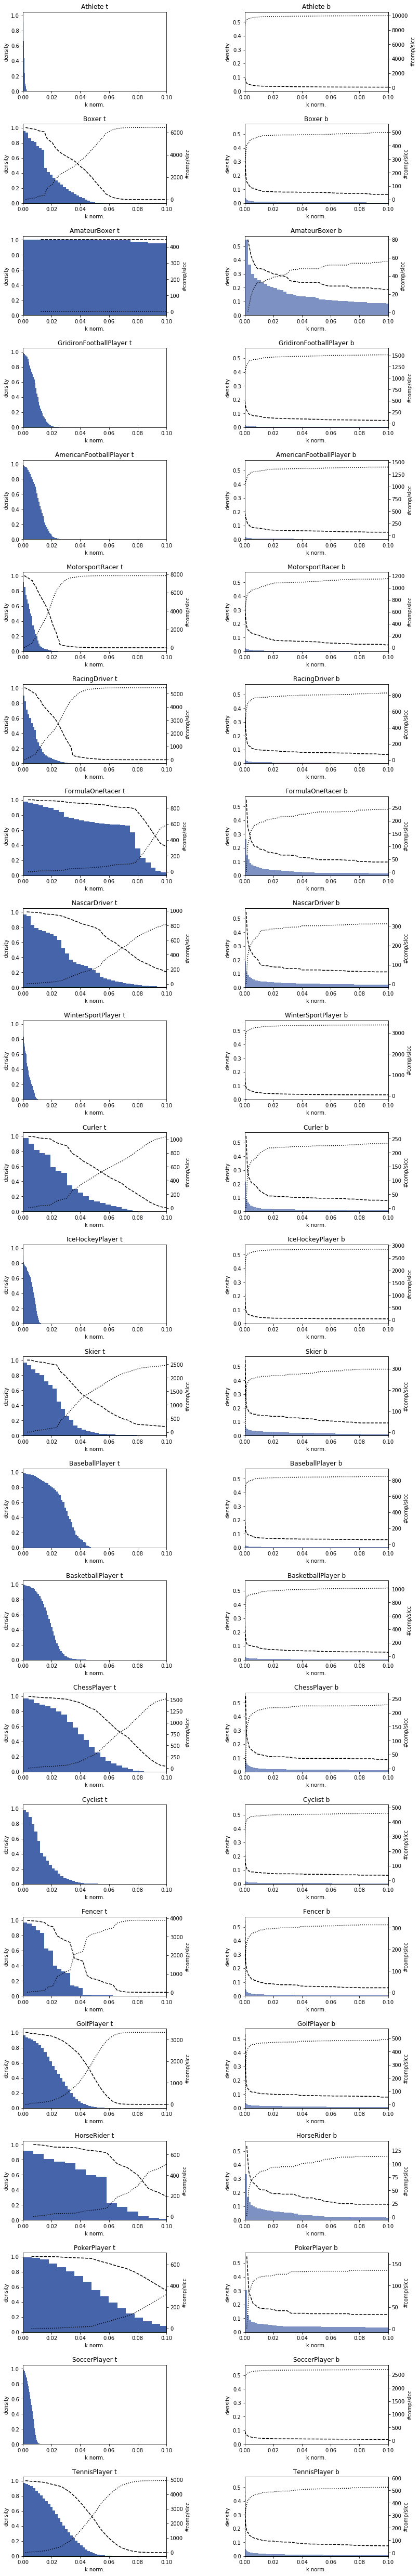

In [12]:
# KNC plots for each superclass and its subclasses

res = res_glob
# Control which classes to analyze. Add or remove rows in res DataFrame
classes = list(res.index.values)

display(res_disp[["n_t", "n_b", "dens_t", "dens_b", "k_0_t", "k_0_b", "rc_dens_t", "rc_dens_b", "rel_rc_t", "rel_rc_b", "superclass"]])

fig, axes = plt.subplots(len(classes), 2, sharex="none", sharey="col", figsize=(12, 3 * len(classes)))

# k_0_t_norm = (res["k_0_t"] / res["n_b"]).max() # Dynamic xmax (Can be very high with small density)
# print("k_0_t_norm", k_0_t_norm)

for classname in classes:
    row = classes.index(classname)
    try:
        df_t = pd.read_csv(f"out/{classname}/{classname}.t.knc.csv")
        df_b = pd.read_csv(f"out/{classname}/{classname}.b.knc.csv")
    except FileNotFoundError as e:
        print(classname, e)
    n_t = res.loc[classname, "n_t"]
    n_b = res.loc[classname, "n_b"]

    # Top
    k = []
    dens = []
    ncomp = []
    slcc = []
    has_ncomp = False
    has_slcc = False
    if "ncomponents" in df_t.columns:
        has_ncomp = True
    if "slcc" in df_t.columns:
        has_slcc = True

    for i, knc_row in df_t.iterrows():
        k.append(knc_row["k"] / n_b)
        dens.append(knc_row["density"])
        if has_ncomp:
            ncomp.append(knc_row["ncomponents"])
        if has_slcc:
            slcc.append(knc_row["slcc"])

    axes[row, 0].set_title(classname + " t")
    axes[row, 0].set_xlabel("k norm.")
    axes[row, 0].set_ylabel("density")
#     axes[row, 0].plot(k, dens)
    axes[row, 0].bar(k, dens, width=(-1/n_b), align="edge", color=kit_blue_1)
    axes[row, 0].set_xlim(0, 0.1)
    if has_ncomp and has_slcc:
        ax2 = axes[row, 0].twinx()
#         k.insert(0, 0)
#         first_ncomp, = ncomp.flat[0]
#         ncomp.insert(0, first_ncomp)
#         first_slcc, = slcc.flat[0]
#         slcc.insert(0, first_slcc)
        ax2.plot(k, ncomp, color="black", linestyle="dotted")
        ax2.plot(k, slcc, color="black", linestyle="dashed")
        ax2.set_ylabel("#comp/slcc")

    # Bot
    k = []
    dens = []
    ncomp = []
    slcc = []
    has_ncomp = False
    has_slcc = False
    if "ncomponents" in df_b.columns:
        has_ncomp = True
    if "slcc" in df_b.columns:
        has_slcc = True

    for i, knc_row in df_b.iterrows():
        k.append(knc_row["k"] / n_t)
        dens.append(knc_row["density"])
        if has_ncomp:
            ncomp.append(knc_row["ncomponents"])
        if has_slcc:
            slcc.append(knc_row["slcc"])

    axes[row, 1].set_title(classname + " b")
    axes[row, 1].set_xlabel("k norm.")
    axes[row, 1].set_ylabel("density")
#     axes[row, 1].plot(k, dens)
    axes[row, 1].bar(k, dens, width=-(1/n_t), align="edge", color=kit_blue_2)
    axes[row, 1].set_xlim(0, 0.1)
    if has_ncomp and has_slcc:
        ax2 = axes[row, 1].twinx()
#         k.insert(0, 0)
#         first_ncomp, = ncomp.flat[0]
#         ncomp.insert(0, first_ncomp)
#         first_slcc, = slcc.flat[0]
#         slcc.insert(0, first_slcc)
        ax2.plot(k, ncomp, color="black", linestyle="dotted")
        ax2.plot(k, slcc, color="black", linestyle="dashed")
        ax2.set_ylabel("#comp/slcc")

plt.subplots_adjust(wspace=50, hspace=10)
plt.tight_layout()

n_t 5, n_b 4, m 10


/home/david/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


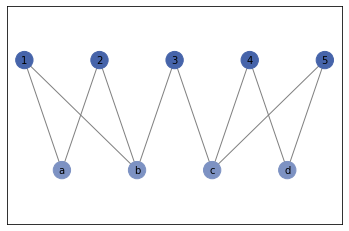

In [13]:
# Example bipartite graphs
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5], bipartite=0)
G.add_nodes_from(["a", "b", "c", "d"], bipartite=1)
# Full connected graph
# G.add_edges_from([(1,"a"),(1,"b"),(1,"c"),(1,"d"),
#                     (2,"a"),(2,"b"),(2,"c"),(2,"d"),
#                     (3,"a"),(3,"b"),(3,"c"),(3,"d"),
#                     (4,"a"),(4,"b"),(4,"c"),(4,"d"),
#                     (5,"a"),(5,"b"),(5,"c"),(5,"d")])
# FiveFour graph
# G.add_edges_from([(1,"a"),(1,"b"),(1,"c"),
#                     (2,"a"),(2,"b"),(2,"c"),
#                     (3,"a"),(3,"b"),(3,"c"),(3,"d"),
#                     (4,"b"),(4,"c"),
#                     (5,"d")])
# Disconnected graph
# G.add_edges_from([(1,"a"),
#                     (2,"b"),
#                     (3,"c"),
#                     (4,"d")])
# 2 Cluster graph
G.add_edges_from([(1,"a"),(1,"b"),
                    (2,"a"),(2,"b"),
                    (3,"b"),(3,"c"),
                    (4,"c"),(4,"d"),
                    (5,"c"),(5,"d")])
top = [1, 2, 3, 4, 5] # top, bot = nx.bipartite.sets(G)
bot = ["a", "b", "c", "d"]
color_dict = {0: kit_blue_1, 1: kit_blue_2}
color_list = [color_dict[i[1]] for i in G.nodes.data("bipartite")]
print(f"n_t {len(top)}, n_b {len(bot)}, m {G.number_of_edges()}")

# bi_layout = nx.bipartite_layout(G, top, align="horizontal", aspect_ratio=20, scale=1)
# nx.draw_networkx(G, bi_layout, font_size=10, edge_color="grey", node_color=color_list)

bot_len = len(bot)
pos = dict()
pos.update((n, (i, 1.1)) for i, n in enumerate(top))
pos.update((n, (i + 0.5, 1)) for i, n in enumerate(bot))
nx.draw_networkx(G, pos=pos, font_size=10, edge_color="grey", node_color=color_list)

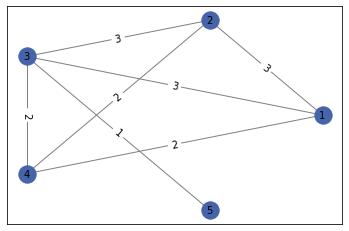

In [14]:
# Example onemode graphs
G = nx.Graph()
# Top mode
# FiveFour graph
G.add_nodes_from([1, 2, 3, 4, 5])
G.add_weighted_edges_from([(1,2,3),(1,3,3),(1,4,2),
                            (2,3,3),(2,4,2),
                            (3,4,2),(3,5,1)])

nx.draw_networkx(G, pos=nx.circular_layout(G, scale=1), font_size=10, edge_color="grey", node_color=kit_blue_1)
labels = nx.get_edge_attributes(G, 'weight')
_ = nx.draw_networkx_edge_labels(G, pos=nx.circular_layout(G, scale=1), edge_labels=labels, font_size=10)

# Full connected graph
# G.add_edges_from([(1,"a"),(1,"b"),(1,"c"),(1,"d"),
#                     (2,"a"),(2,"b"),(2,"c"),(2,"d"),
#                     (3,"a"),(3,"b"),(3,"c"),(3,"d"),
#                     (4,"a"),(4,"b"),(4,"c"),(4,"d"),
#                     (5,"a"),(5,"b"),(5,"c"),(5,"d")])

# Disconnected graph
# G.add_edges_from([(1,"a"),
#                     (2,"b"),
#                     (3,"c"),
#                     (4,"d")])
# 2 Cluster graph
# G.add_edges_from([(1,"a"),(1,"b"),
#                     (2,"a"),(2,"b"),
#                     (3,"b"),(3,"c"),
#                     (4,"c"),(4,"d"),
#                     (5,"c"),(5,"d")])

# G.add_nodes_from(["a", "b", "c", "d"])